In [57]:
import time

In [58]:
import pandas as pd

df = pd.read_csv('../../data/raw/smart_meters_london_2013.csv')

In [59]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [60]:
PROFILES = 1031

In [61]:
df = df.iloc[:, :PROFILES]

In [62]:
df

,0,1,2,3,4,5,6,7,8,9,...,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.460,3.888,0.000,0.207,0.000,0.451,0.962,0.579,0.016,0.660,...,0.227,1.469,0.141,0.136,0.442,0.576,0.318,0.283,0.520,0.285
2013-01-01 01:00:00,0.426,2.603,0.158,0.106,0.000,0.375,1.121,1.340,0.107,0.420,...,0.234,1.472,0.156,0.258,0.091,0.185,0.202,0.245,1.042,0.326
2013-01-01 02:00:00,0.411,2.159,0.000,0.069,0.000,0.312,0.373,1.431,0.024,0.242,...,0.043,1.484,0.094,0.496,0.169,0.163,0.306,0.881,1.179,0.360
2013-01-01 03:00:00,0.395,2.040,0.170,0.065,0.000,0.199,0.421,0.413,0.010,0.149,...,0.100,1.522,0.096,0.111,0.152,0.162,0.056,0.128,0.358,0.308
2013-01-01 04:00:00,0.221,1.495,0.000,0.058,0.000,0.096,0.303,0.230,0.107,0.280,...,0.037,1.590,0.105,0.122,0.062,0.151,0.113,0.142,0.231,0.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.559,0.221,0.169,0.281,0.227,1.383,2.574,1.229,0.030,0.656,...,0.217,0.431,0.154,1.613,0.546,1.133,1.415,0.000,1.411,1.913
2013-12-31 20:00:00,1.233,0.140,0.000,0.286,0.218,0.643,2.589,1.314,0.000,0.670,...,0.085,0.526,0.420,0.854,0.496,1.350,0.471,0.000,1.244,0.999
2013-12-31 21:00:00,0.783,0.120,0.178,0.209,0.209,1.000,1.647,0.906,0.101,0.556,...,0.058,0.528,0.113,0.877,0.414,0.376,0.175,0.000,0.900,0.321


In [63]:
import matplotlib
import matplotlib.pyplot as plt

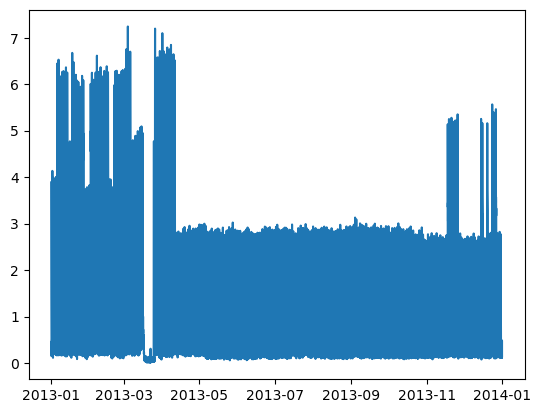

In [64]:
plt.plot(df["1"])

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')



Using GPU


In [67]:
results_path = Path('time_gan')

In [68]:
experiment = 0

In [69]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [70]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

In [71]:
tickers = ['A', 'B', 'C', 'D', 'E', 'F']

In [72]:
seq_len = 24
n_seq = PROFILES
batch_size = 128

In [73]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

In [74]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

In [75]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [76]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [77]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

In [78]:
hidden_dim = 24
num_layers = 3

In [79]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [80]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [81]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [82]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

In [83]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

In [84]:
train_steps = 1500
gamma = 1

mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [85]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [86]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 1031)]        0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            83904     
                                                                 
 Recovery (Sequential)       (None, 24, 1031)          36575     
                                                                 
Total params: 120479 (470.62 KB)
Trainable params: 120479 (470.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


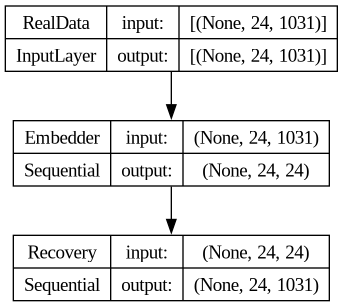

In [87]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

In [88]:
autoencoder_optimizer = Adam()

In [89]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [90]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 1500/1500 [00:20<00:00, 71.81it/s] 


In [91]:
supervisor_optimizer = Adam()

In [92]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [93]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 1500/1500 [00:14<00:00, 105.59it/s]


###  Joint Training

##   Generator

In [94]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [95]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1031)]        0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            83904     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 102529 (400.50 KB)
Trainable params: 102529 (400.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


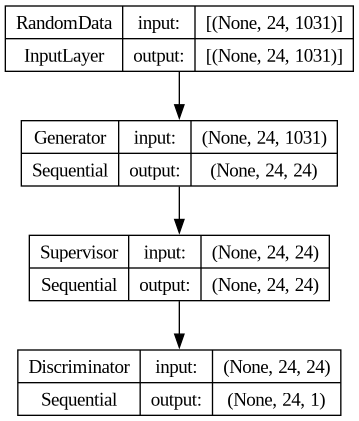

In [96]:
plot_model(adversarial_supervised, show_shapes=True)

In [97]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [98]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1031)]        0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            83904     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 94729 (370.04 KB)
Trainable params: 94729 (370.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


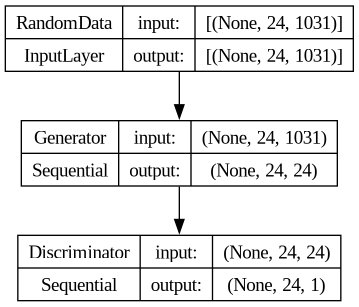

In [99]:
plot_model(adversarial_emb, show_shapes=True)

In [100]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [101]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1031)]        0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            83904     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 1031)          36575     
                                                                 
Total params: 128279 (501.09 KB)
Trainable params: 128279 (501.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


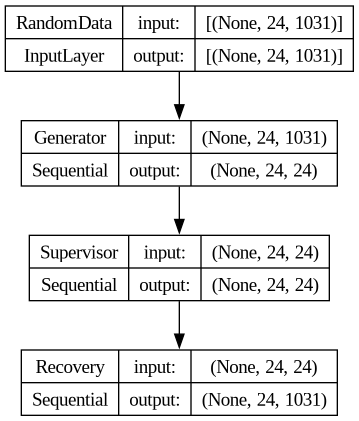

In [102]:
plot_model(synthetic_data, show_shapes=True)

In [103]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

##  Discriminator

In [104]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [105]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 1031)]        0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            83904     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 94729 (370.04 KB)
Trainable params: 94729 (370.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


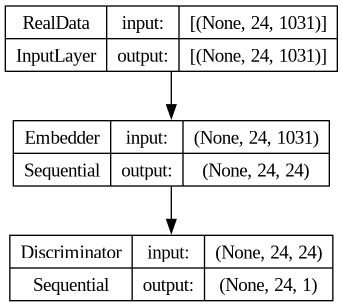

In [106]:
plot_model(discriminator_model, show_shapes=True)

In [107]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

##  Generator Train Step

In [108]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

### Embedding Train Step

In [109]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

###  Discriminator Train Step

In [110]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [111]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

###  Training Loop

In [112]:
# Start the timer
start_time = time.time()

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

     0 | d_loss: 2.2180 | g_loss_u: 0.5860 | g_loss_s: 0.0000 | g_loss_v: 0.1067 | e_loss_t0: 0.1070
 1,000 | d_loss: 1.9682 | g_loss_u: 1.5269 | g_loss_s: 0.0005 | g_loss_v: 0.0415 | e_loss_t0: 0.0869
Elapsed time: 359.16 seconds


In [113]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


In [114]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [115]:
len(generated_data)

68

In [116]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(8704, 24, 1031)

In [117]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [118]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(8704, 24, 1031)

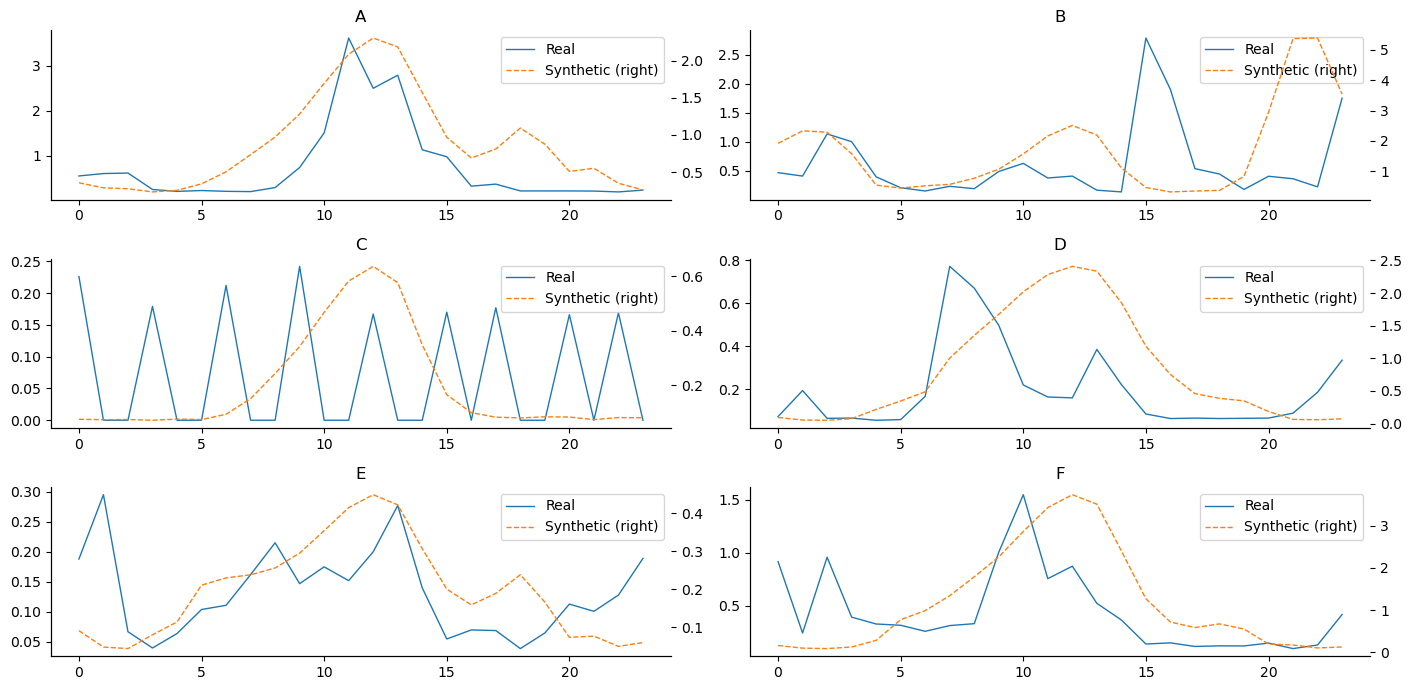

In [119]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()